## Fine Tuning BERT For Sentiment Classification

This notebook uses BERT to perform sentiment classification. A great tutorial for fine tuning BERT can be found here: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

We may not always have access to GPU, in which case, training to defer back to using CPU.

As a rule of thumb, reviews that are 3 stars and above are **positive**, and vice versa.

In [1]:
#!pip install transformers

In [2]:
#!pip install torch

In [3]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
import torch
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from transformers import BertTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

In [4]:
torch.cuda.empty_cache()

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-PCIE-16GB


In [6]:
RANDOM_SEED = 33

In [7]:
reviews_sg = pd.read_pickle("assets/sg_reviews.pkl")
reviews_sg.head()

,date,review,rating,app
0,2020-09-30,"Used to be a good app been using for years, no...",5,GrabFood
1,2020-08-21,Grab app is convenient because you can use mul...,1,GrabFood
2,2020-11-18,I used to love the subscription plans that the...,1,GrabFood
3,2021-11-06,I ordered a grabfood and one of the 3 items ar...,1,GrabFood
4,2021-09-26,This platform gives too much power to restaura...,1,GrabFood


In [8]:
reviews_sg['label'] = np.where(reviews_sg['rating'] >= 3, 0, 1)

In [9]:
reviews_sg.head()

,date,review,rating,app,label
0,2020-09-30,"Used to be a good app been using for years, no...",5,GrabFood,0
1,2020-08-21,Grab app is convenient because you can use mul...,1,GrabFood,1
2,2020-11-18,I used to love the subscription plans that the...,1,GrabFood,1
3,2021-11-06,I ordered a grabfood and one of the 3 items ar...,1,GrabFood,1
4,2021-09-26,This platform gives too much power to restaura...,1,GrabFood,1


## 1. Data Processing

In [10]:
reviews_sg.isnull().sum()

date       0
review    87
rating     0
app        0
label      0
dtype: int64

In [11]:
reviews_sg = reviews_sg.dropna()

In [12]:
df_proc = reviews_sg.copy()
df_proc.drop(columns=['date', 'rating', 'app'], inplace=True)
df_proc.head()

,review,label
0,"Used to be a good app been using for years, no...",0
1,Grab app is convenient because you can use mul...,1
2,I used to love the subscription plans that the...,1
3,I ordered a grabfood and one of the 3 items ar...,1
4,This platform gives too much power to restaura...,1


In [13]:
X = df_proc['review']
y = df_proc['label']

We will split the dataset into `train`, and `dev` (at this point I don't see the point of using a test set, since I'm not doing cross validation). But ideally, I want the dev set to be the same across all different training sizes.

We'll also try to stratify our dataset when we split.

In [14]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
#X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED)

In [15]:
len(X_train)

527677

In [16]:
len(X_dev)

131920

In [17]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,review,label
259477,Top discount food delivery app in Cambodia,0
437548,Superb discounts,0
124328,veri good aps,0
318037,This is very good app and their service was ve...,0
128965,🙂,0


Split again to get a subset of the train dataset. We only want 100k to train.

In [18]:
X_disc, X_train, y_disc, y_train = train_test_split(X_train, y_train, 
                                                    test_size=100000, random_state=RANDOM_SEED, stratify=y_train)

In [19]:
len(X_train)

100000

In [20]:
X_train.iloc[0]

"It's amazing"

In [21]:
X_dev.iloc[0]

'Cool'

## 2. BERT Tokenization

It is a requirement to use BERT tokenization. Prior to that, the example notebook also provided a function for some basic text processing, albeit much less (according to the notebook, this is because BERT was trained with the entire sentences?).



In [22]:
def text_preprocessing(text):
    """
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)
    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [23]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            truncation=True,
            padding='max_length',           # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

And apparently, we need to find the max length of our sentence to later feed into the function above.

In [24]:
# Encode our concatenated data
encoded_reviews = [tokenizer.encode(review, add_special_tokens=True) for review in df_proc.review]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_reviews])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


Max length:  827


In [25]:
# Specify `MAX_LEN`
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X.values[0]])[0].squeeze().numpy())
print('Original: ', X.values[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
# Note that the function takes in a numpy array
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train.values)
dev_inputs, dev_masks = preprocessing_for_bert(X_dev.values)

Original:  Used to be a good app been using for years, now pools orders sending poor drivers in circles and baiting customers with artificial delivery time. 

2 orders today and both messed up, 1 with half the drinks spilt over the food and the other delayed, because platform decided to pool orders. Called customer service for the 2nd one to ask if I could change the location as I had to leave, they directed me to arrange with the driver. Called the driver - says did not receive permission to modify location from customer service.

Poor drivers so stressed not being able to meet clearly impossible timings app promised its customers to bait their orders. Customers not able to plan their time cos app doesnt respect their time. Am a platinum member too so dont kid yourself thinking service improves with increased use/ loyalty. Better luck with foodpanda, deliveroo or other more reliable companies.
Token IDs:  [101, 2109, 2000, 2022, 1037, 2204, 10439, 2042, 2478, 2005, 2086, 1010, 2085, 1

Now create a torch DataLoader class, which is meant to save memory during training and boost training speed.

In [26]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
dev_labels = torch.tensor(y_dev.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
dev_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

## 3. Model Training

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

### 3.1 Create Classifier

In [27]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 18.1 ms, sys: 3.98 ms, total: 22 ms
Wall time: 31.5 ms


### 3.2 Create Optimizer

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the `run_glue.py` script, an examples of implementing the transformers library. In the script, the AdamW optimizer is used.

In [28]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3 Create a Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (loss.backward())
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (optimizer.step())
- Update the learning rate (scheduler.step())

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set
The script below is commented with the details of our training and evaluation loop.

In [29]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=33):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 200 batches
            if (step % 200 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            dev_loss, dev_accuracy = evaluate(model, dev_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {dev_loss:^10.6f} | {dev_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, dev_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    dev_accuracy = []
    dev_loss = []

    # For each batch in our validation set...
    for batch in dev_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        dev_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        dev_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the development set.
    dev_loss = np.mean(dev_loss)
    dev_accuracy = np.mean(dev_accuracy)

    return dev_loss, dev_accuracy

In [30]:
set_seed(33)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, dev_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   0.310468   |     -      |     -     |  101.89  
   1    |   400   |   0.276057   |     -      |     -     |  101.50  
   1    |   600   |   0.265103   |     -      |     -     |  101.62  
   1    |   800   |   0.270035   |     -      |     -     |  101.63  
   1    |  1000   |   0.260996   |     -      |     -     |  101.64  
   1    |  1200   |   0.255277   |     -      |     -     |  101.39  
   1    |  1400   |   0.247066   |     -      |     -     |  101.31  
   1    |  1600   |   0.241136   |     -      |     -     |  101.33  
   1    |  1800   |   0.241802   |     -      |     -     |  101.32  
   1    |  2000   |   0.240671   |     -      |     -     |  101.33  
   1    |  2200   |   0.246348   |     -      |     -     |  101.33  
   1    |  2400   |   0.252665   |     -      |     -     |  101.33  


### 3.4 Evaluation on Development Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [31]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [32]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9610
Accuracy: 91.99%


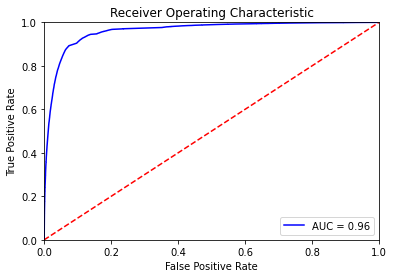

In [33]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, dev_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_dev)

In [34]:
# Get predictions from the probabilities
threshold = 0.5
y_dev_pred = np.where(probs[:, 1] > threshold, 1, 0)

In [35]:
score = accuracy_score(y_dev, y_dev_pred)
print("accuracy:   %0.3f" % score)
print("classification report:")
print(classification_report(y_dev, y_dev_pred))
print("confusion matrix:")
print(confusion_matrix(y_dev, y_dev_pred))
print("Training Complete")
print()

accuracy:   0.920
classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     97623
           1       0.83      0.86      0.85     34297

    accuracy                           0.92    131920
   macro avg       0.89      0.90      0.90    131920
weighted avg       0.92      0.92      0.92    131920

confusion matrix:
[[91753  5870]
 [ 4697 29600]]
Training Complete



In [36]:
torch.save(bert_classifier, 'bert_sg_small')

In [37]:
saved_model = torch.load('bert_sg_small')

Making sure that the saved model works...

AUC: 0.9610
Accuracy: 91.99%


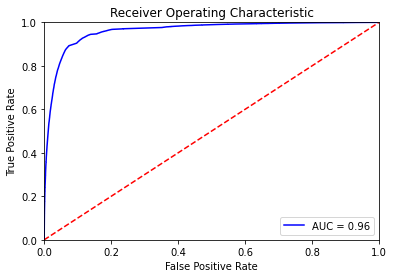

In [38]:
# Compute predicted probabilities on the test set
probs_load_test = bert_predict(saved_model, dev_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs_load_test, y_dev)

In [39]:
threshold = 0.5
y_dev_pred_load_test = np.where(probs_load_test[:, 1] > threshold, 1, 0)

In [40]:
score = accuracy_score(y_dev, y_dev_pred_load_test)
print("accuracy:   %0.3f" % score)
print("classification report:")
print(classification_report(y_dev, y_dev_pred_load_test))
print("confusion matrix:")
print(confusion_matrix(y_dev, y_dev_pred_load_test))
print("Training Complete")
print()

accuracy:   0.920
classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     97623
           1       0.83      0.86      0.85     34297

    accuracy                           0.92    131920
   macro avg       0.89      0.90      0.90    131920
weighted avg       0.92      0.92      0.92    131920

confusion matrix:
[[91753  5870]
 [ 4697 29600]]
Training Complete



FINALLY.

In [41]:
torch.save(bert_classifier, 'bert_sg_small.pth')